In [134]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan

k_neighbors = 50
k_neighbors += 1

In [ ]:
patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata.shape

In [ ]:
#Build L Matrix
ANNOY_PATH = "../../../large_data_files"
annoy_path = os.path.join(ANNOY_PATH, "200214_patient_similarity_clusters_default.ann")

cos_knn_tree = AnnoyIndex(pdata.shape[1], "angular")
cos_knn_tree.load(annoy_path)

gamma = 2
print("Building dense data matrix with k={} nn...".format(k_neighbors))
A = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    nn_idxs = cos_knn_tree.get_nns_by_item(i, k_neighbors)[1:]
    cos_distances = [cos_knn_tree.get_distance(i, nn) for nn in nn_idxs]
    rbf_distances = [np.exp(-gamma*cos_dist**2) for cos_dist in cos_distances]
    A[i, nn_idxs] = rbf_distances
    
D = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    D[i, i] = np.sum(A[i])

In [ ]:
pickle.dump(csr_matrix(A), open("A_sym_K{}_CSR.p".format(k_neighbors - 1), "wb"))
pickle.dump(csr_matrix(D), open("D_sym_K{}_CSR.p".format(k_neighbors - 1), "wb"))

In [ ]:
A_sym = pickle.load(open("A_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))
D_sym = pickle.load(open("D_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))

print(D_sym[0, 0])
nonzero_idx = np.nonzero(D_sym)
D_diag_sqrt_inv = 1.0/np.sqrt(D_sym[nonzero_idx])

D_inv_sqrt = D_sym
D_inv_sqrt[nonzero_idx] = D_diag_sqrt_inv

In [ ]:
pickle.dump(D_inv_sqrt, open("D_sym_inv_sqrt_K{}_CSR.p".format(k_neighbors - 1), "wb"))

In [ ]:
A_sym = pickle.load(open("A_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))
D_sym_inv_sqrt = pickle.load(open("D_sym_inv_sqrt_K{}_CSR.p".format(k_neighbors - 1), "rb"))

print("computing L...")
L = D_sym_inv_sqrt.multiply(A_sym.multiply(D_sym_inv_sqrt))
pickle.dump(csr_matrix(L), open("L_sym_K{}_CSR.p".format(k_neighbors - 1), "wb"))

# Eigen Decomposition

In [15]:
k_neighbors = 50
k_neighbors += 1
L = pickle.load(open("L_sym_K{}_CSR.p".format(k_neighbors - 1), "rb")).toarray()
eigs=100
# print("Found nans:", np.any(np.isnan(L)))

In [ ]:
L_evals = pickle.load(open("L_evals_eigs{}_K{}.p".format(eigs, k_neighbors - 1), "rb"))

In [16]:
L_evals, L_evecs = scipy.sparse.linalg.eigsh(L, k=eigs)

Nans shape: (0, 1)


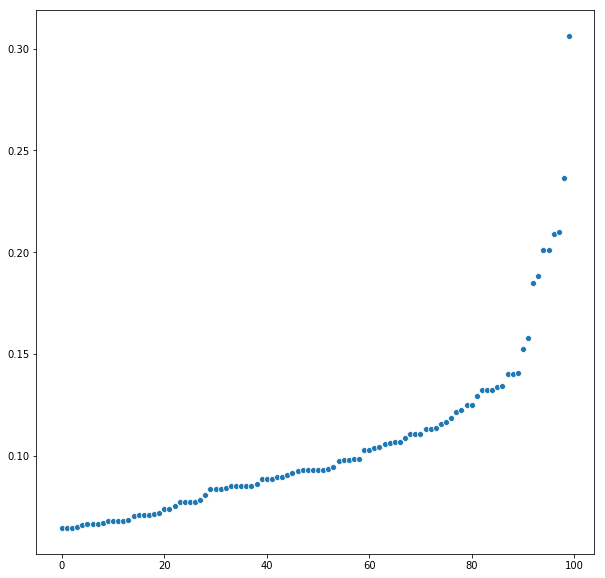

In [17]:
L_nan_idxs = np.argwhere(np.isnan(L_evals))
print("Nans shape:", L_nan_idxs.shape)

plt.figure(figsize=(10,10))
sns.scatterplot(range(L_evals.shape[0]), L_evals)
plt.savefig("eigen_vals_sparse_eigs{}_L_K{}.png".format(eigs, k_neighbors - 1))

In [6]:
pickle.dump(L_evals, open("L_evals_eigs{}_K{}.p".format(eigs, k_neighbors - 1), "wb"))

## Standardized Decomposition

In [7]:
L_standardized = pickle.load(open("L_standardized_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))
L_standardized

<46520x46520 sparse matrix of type '<class 'numpy.float64'>'
	with 2100 stored elements in Compressed Sparse Row format>

In [ ]:
L_std = np.std(L, axis=0)
L_mean = np.mean(L, axis=0)
print(np.nonzero(L_std)[0])
print(np.nonzero(L_mean)[0])
print(np.all(np.nonzero(L_std)[0] == np.nonzero(L_mean)[0]))
print("^ This means mean and std are nonzero at exactly the same places...")

L_standardized = np.subtract(L, L_mean, where=L_std!=0)
L_standardized = np.divide(L, L_std, where=L_std!=0)

In [ ]:
print(np.mean(L_standardized[:, 67]))
print(np.std(L_standardized[:, 67]))

In [ ]:
pickle.dump(csr_matrix(L_standardized), open("L_standardized_sym_K{}_CSR.p".format(k_neighbors - 1), "wb"))

Nans shape: (0, 1)


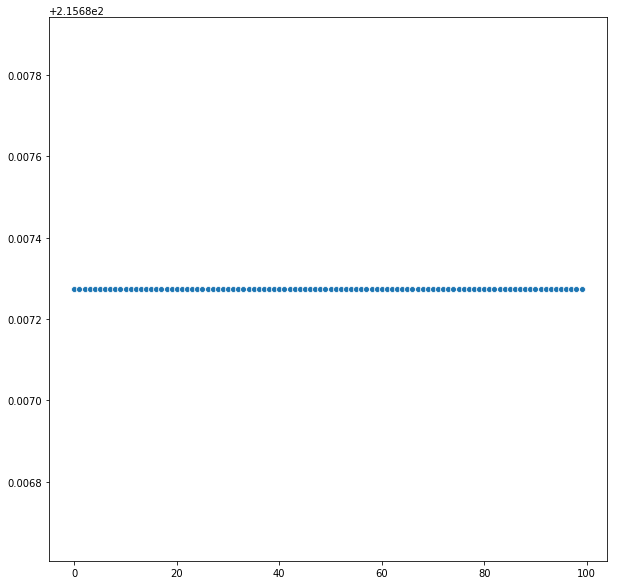

In [8]:
e_std = 100
L_standardized_evals, L_standardized_evecs = scipy.sparse.linalg.eigsh(L_standardized, k=e_std)

L_standardized_nan_idxs = np.argwhere(np.isnan(L_standardized_evals))
print("Nans shape:", L_standardized_nan_idxs.shape)

plt.figure(figsize=(10,10))
sns.scatterplot(range(L_standardized_evals.shape[0]), L_standardized_evals)
plt.savefig("eigen_vals_eigs{}_L_standardized_K{}.png".format(e_std, k_neighbors - 1))

In [9]:
pickle.dump(L_standardized_evals, open("L_standardized_evals_eigs{}_K{}.p".format(e_std, k_neighbors - 1), "wb"))

In [13]:
a = np.array([[1,1,1],[2,2,2],[3,3,3]])
b = np.array([1,2,3])

print(a / b[:, None])

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


# Cluster

In [45]:
X = L_evecs
L_evecs_lengths = np.linalg.norm(X, axis=1)

Y = X / L_evecs_lengths[:, None]

In [147]:
Y_pca = PCA().fit(Y.T)

In [122]:
n_feats = 5
print(np.sum(Y_pca.explained_variance_ratio_[:n_feats]))

0.9422903453431334


In [123]:
Y_pca_feats = Y_pca.components_[:n_feats].T
Y_pca_feats.shape

(46520, 5)

In [132]:
n_clusters = 3
Y_kmeans = KMeans(n_clusters=n_clusters).fit(Y_pca_feats)
Y_cluster_labels = Y_kmeans.labels_
np.unique(Y_cluster_labels)

array([0, 1, 2], dtype=int32)

In [129]:
visualizer = Visualizer()
Y_umap_2d = visualizer.umap_embedding(Y_pca_feats, n_components=2)
Y_umap_3d = visualizer.umap_embedding(Y_pca_feats, n_components=3)

pickle.dump(Y_umap_2d, open("Y_umap_2d_pca{}.p".format(n_feats), 'wb'))
pickle.dump(Y_umap_3d, open("Y_umap_3d_pca{}.p".format(n_feats), 'wb'))

./../../src/visualizer_helper.py:21: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components).fit_transform(X)


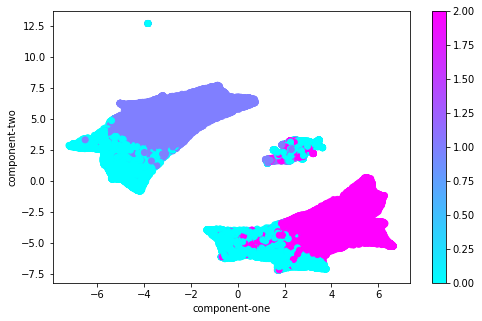

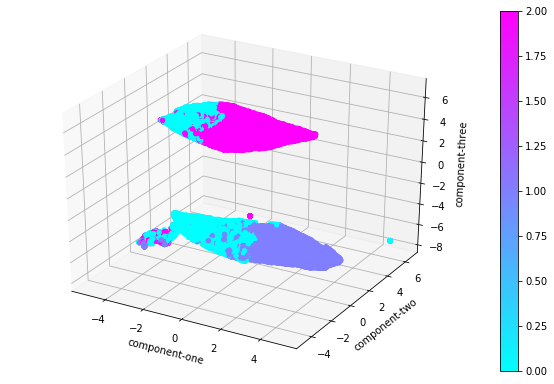

In [133]:
Y_umap_2d = pickle.load(open("Y_umap_2d_pca{}.p".format(n_feats), 'rb'))
Y_umap_3d = pickle.load(open("Y_umap_3d_pca{}.p".format(n_feats), 'rb'))

alpha = 1
visualizer.plot2d(
    X=Y_umap_2d, 
    filename="Patient_Clusters_2D_spectral_K{}_eig{}_pca{}_clusters{}".format(k_neighbors - 1, eigs, n_feats, n_clusters), 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename="Patient_Clusters_3D_spectral_K{}_eig{}_pca{}_clusters{}".format(k_neighbors - 1, eigs, n_feats, n_clusters), 
    colors=Y_cluster_labels,
    alpha = alpha
)

# HDBSCAN

In [ ]:
n_feats = 8
minclustersize = 10

Y_pca_feats = Y_pca.components_[:n_feats].T

hdbscanner = hdbscan.HDBSCAN(min_cluster_size=minclustersize).fit(Y_pca_feats)
hdbscan_labels = hdbscanner.fit_predict(Y_pca_feats)
np.unique(hdbscan_labels, return_counts=True)

In [160]:
visualizer = Visualizer()
Y_umap_2d = visualizer.umap_embedding(Y_pca_feats, n_components=2)
Y_umap_3d = visualizer.umap_embedding(Y_pca_feats, n_components=3)

pickle.dump(Y_umap_2d, open("Y_umap_2d_pca{}.p".format(n_feats), 'wb'))
pickle.dump(Y_umap_3d, open("Y_umap_3d_pca{}.p".format(n_feats), 'wb'))

./../../src/visualizer_helper.py:21: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components).fit_transform(X)


In [ ]:
Y_umap_2d = pickle.load(open("Y_umap_2d_pca{}.p".format(n_feats), 'rb'))
Y_umap_3d = pickle.load(open("Y_umap_3d_pca{}.p".format(n_feats), 'rb'))

alpha = 1
visualizer.plot2d(
    X=Y_umap_2d, 
    filename="Patient_Clusters_2D_spectral_HDB_K{}_eig{}_pca{}_minclustersize{}".format(k_neighbors - 1, eigs, n_feats, minclustersize), 
    colors=hdbscan_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename="Patient_Clusters_3D_spectral_HDB_K{}_eig{}_pca{}_minclustersize{}".format(k_neighbors - 1, eigs, n_feats, minclustersize), 
    colors=hdbscan_labels,
    alpha = alpha
)

# Misc

In [ ]:
icd_idx = 0
icd_row = A_sym[icd_idx]
has_icd = np.nonzero(icd_row)[1]
has_icd

In [ ]:
def sort_pdata(pdata, unwanted = set([])):
    icd_x_patients = pdata.T
    sorted_idx = []
    seen = set([])

    for icd_idx in tqdm(range(icd_x_patients.shape[0])):
        if icd_idx in unwanted:
            continue
        icd_row = icd_x_patients[icd_idx]
        has_icd = set(np.nonzero(icd_row)[1])
        has_icd -= seen
        sorted_idx += list(has_icd)
        seen.update(sorted_idx)
        
    icd_x_patients_sorted = pdata[sorted_idx].T
    print(len(seen))
    return icd_x_patients_sorted

A_sorted = sort_pdata(A_sym)
A_sorted[A_sorted > 0] = 1

In [ ]:
plt.figure(figsize=(40, 20))
sns.heatmap(A_sorted.toarray()[:2000, :2000])
plt.savefig("heatmap_A_K{}.png".format(k_neighbors - 1))